## 0. Introduction
this notebook shows the model training inculding spliting, sloving imblance cat. and training and eval.


In [53]:
!pip install imbalanced-learn

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

from imblearn.over_sampling import SMOTE

## 1. Load Data

In [84]:
df = pd.read_csv("../data/cleaned_telecom_churn_data.csv")


## 2. Identify feature types

In [ ]:
df["tenure_group"] = pd.cut(
        df["tenure"],
        bins=[0, 12, 24, 48, 60, 72],
        labels=["0-1yr","1-2yr","2-4yr","4-5yr","5-6yr"]
    )
# service_cols = [
#         "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity",
#         "OnlineBackup", "DeviceProtection", "TechSupport", 
#         "StreamingTV", "StreamingMovies"
#     ]
    
# df["services_count"] = df[service_cols].apply(
#         lambda row: sum([1 if val in [1, "Yes"] else 0 for val in row]),
#         axis=1
#     )
# df["senior_no_tech"] = df.apply(
#         lambda x: 1 if (x["SeniorCitizen"] == 1 and x["TechSupport"] == "No") else 0,
#         axis=1
#     )

In [86]:
X = df.drop(["Churn",'tenure'], axis=1)
y = df["Churn"] 

In [87]:
numeric_features = ["MonthlyCharges", "TotalCharges"]
categorical_features = [
    "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaymentMethod",'tenure_group'
]

In [88]:
X.sample()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_group
1948,1,0,0,1,1,No,Fiber optic,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,75.35,75.35,0-1yr


## 3. Preprocessing pipeline

In [89]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_processed = preprocessor.fit_transform(X)

## 4. Model Training Experiments

### 4.1. Split Data

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42, stratify=y)

In [91]:
X_train.shape

(4922, 38)

### 4.2. Define Models

In [92]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    # 'catboost': CatBoostClassifier(random_state=42, verbose=0),
    # 'adaBoost': AdaBoostClassifier(random_state=42),    
    # 'lgbm': LGBMClassifier(random_state=42)
}

### 4.3. Experiment A: Baseline Models

In [93]:
expA_results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    expA_results.append({
        "Model": name,
        "Accuracy": accuracy,
        "F1": f1,
        "Recall": recall,
        "Precision": precision,
        "Experiment": "Original"
    })

expA_results = pd.DataFrame(expA_results)
display(expA_results)

,Model,Accuracy,F1,Recall,Precision,Experiment
0,LogisticRegression,0.785782,0.552475,0.497326,0.621381,Original
1,SVC,0.782938,0.511727,0.427807,0.636605,Original
2,RandomForest,0.760190,0.507782,0.465241,0.558887,Original
3,GradientBoosting,0.786730,0.550000,0.490196,0.626424,Original
4,XGBoost,0.782938,0.559615,0.518717,0.607516,Original


### 4.4. Experiment B: Cross-Validation and Hyperparameter Tuning

In [94]:
param_grid = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs']
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.2]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
}

X_train_orig, y_train_orig = X_train, y_train

In [98]:
expB_results = []

for name, model in models.items():
    print(f"\nRunning GridSearchCV for {name}...")
    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='f1')
    grid_search.fit(X_train_bal, y_train_bal)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    expB_results.append({
        "Model": name,
        "Accuracy": accuracy,
        "F1": f1,
        "Recall": recall,
        "Precision": precision,
        "Experiment": "CV + Hyperparam"
    })

expB_results = pd.DataFrame(expB_results)
display(expB_results)


Running GridSearchCV for LogisticRegression...

Running GridSearchCV for SVC...

Running GridSearchCV for SVC...

Running GridSearchCV for RandomForest...

Running GridSearchCV for RandomForest...

Running GridSearchCV for GradientBoosting...

Running GridSearchCV for GradientBoosting...

Running GridSearchCV for XGBoost...

Running GridSearchCV for XGBoost...


,Model,Accuracy,F1,Recall,Precision,Experiment
0,LogisticRegression,0.740284,0.615708,0.782531,0.507514,CV + Hyperparam
1,SVC,0.743128,0.565008,0.627451,0.513869,CV + Hyperparam
2,RandomForest,0.756872,0.551965,0.563280,0.541096,CV + Hyperparam
3,GradientBoosting,0.785308,0.631408,0.691622,0.580838,CV + Hyperparam
4,XGBoost,0.781517,0.621821,0.675579,0.575988,CV + Hyperparam


In [99]:
expB_results = pd.DataFrame(expB_results)
display(expB_results)

,Model,Accuracy,F1,Recall,Precision,Experiment
0,LogisticRegression,0.740284,0.615708,0.782531,0.507514,CV + Hyperparam
1,SVC,0.743128,0.565008,0.627451,0.513869,CV + Hyperparam
2,RandomForest,0.756872,0.551965,0.563280,0.541096,CV + Hyperparam
3,GradientBoosting,0.785308,0.631408,0.691622,0.580838,CV + Hyperparam
4,XGBoost,0.781517,0.621821,0.675579,0.575988,CV + Hyperparam


### 4.5. Experiment C: Addressing Class Imbalance

In [95]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_orig, y_train_orig)

In [96]:
y_train_bal.value_counts()

Churn
1    3614
0    3614
Name: count, dtype: int64

In [102]:
expC_results = []

for name, model in models.items():
    print(f"\nRunning Balanced Experiment for {name}...")
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    expC_results.append({
        "Model": name,
        "Accuracy": accuracy,
        "F1": f1,
        "Recall": recall,
        "Precision": precision,
        "Experiment": "Balanced"
    })

expC_results = pd.DataFrame(expC_results)
display(expC_results)


Running Balanced Experiment for LogisticRegression...

Running Balanced Experiment for SVC...

Running Balanced Experiment for RandomForest...

Running Balanced Experiment for GradientBoosting...

Running Balanced Experiment for XGBoost...


,Model,Accuracy,F1,Recall,Precision,Experiment
0,LogisticRegression,0.743602,0.618746,0.782531,0.511655,Balanced
1,SVC,0.741706,0.605358,0.745098,0.509756,Balanced
2,RandomForest,0.754976,0.541260,0.543672,0.538869,Balanced
3,GradientBoosting,0.778673,0.632573,0.716578,0.566197,Balanced
4,XGBoost,0.770142,0.580087,0.597148,0.563973,Balanced


#### Experiment C_V2: stacking

In [100]:
from sklearn.ensemble import StackingClassifier

# Define base estimators
estimators = [
    ("rf", RandomForestClassifier(n_estimators=200, random_state=42)),
    ("xgb", XGBClassifier(random_state=42, eval_metric="logloss")),
    ("gboost", GradientBoostingClassifier(random_state=42)),
    ("svm", SVC(probability=True, random_state=42))
]

# Meta model
meta_estimator = LogisticRegression(max_iter=1000, random_state=42)

# Stacking classifier (train on balanced data to address imbalance)
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_estimator,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

print("Training StackingClassifier on balanced training set...")
stack_clf.fit(X_train_bal, y_train_bal)

y_pred_stack = stack_clf.predict(X_test)

accuracy_stack = accuracy_score(y_test, y_pred_stack)
f1_stack = f1_score(y_test, y_pred_stack)
recall_stack = recall_score(y_test, y_pred_stack)
precision_stack = precision_score(y_test, y_pred_stack)

stack_result = pd.DataFrame([{
    "Model": "Stacking(LogisticMeta)",
    "Accuracy": accuracy_stack,
    "F1": f1_stack,
    "Recall": recall_stack,
    "Precision": precision_stack,
    "Experiment": "Stacking (Balanced)"
}])

display(stack_result)

expC_results = pd.concat([expC_results, stack_result], ignore_index=True)
display(expC_results)

Training StackingClassifier on balanced training set...


,Model,Accuracy,F1,Recall,Precision,Experiment
0,Stacking(LogisticMeta),0.771564,0.579407,0.5918,0.567521,Stacking (Balanced)


,Model,Accuracy,F1,Recall,Precision,Experiment
0,LogisticRegression,0.743602,0.618746,0.782531,0.511655,Balanced
1,SVC,0.741706,0.605358,0.745098,0.509756,Balanced
2,RandomForest,0.754976,0.541260,0.543672,0.538869,Balanced
3,GradientBoosting,0.778673,0.632573,0.716578,0.566197,Balanced
4,XGBoost,0.770142,0.580087,0.597148,0.563973,Balanced
5,Stacking(LogisticMeta),0.771564,0.579407,0.591800,0.567521,Stacking (Balanced)


## 5. Comparing Results and Selecting the Best Model

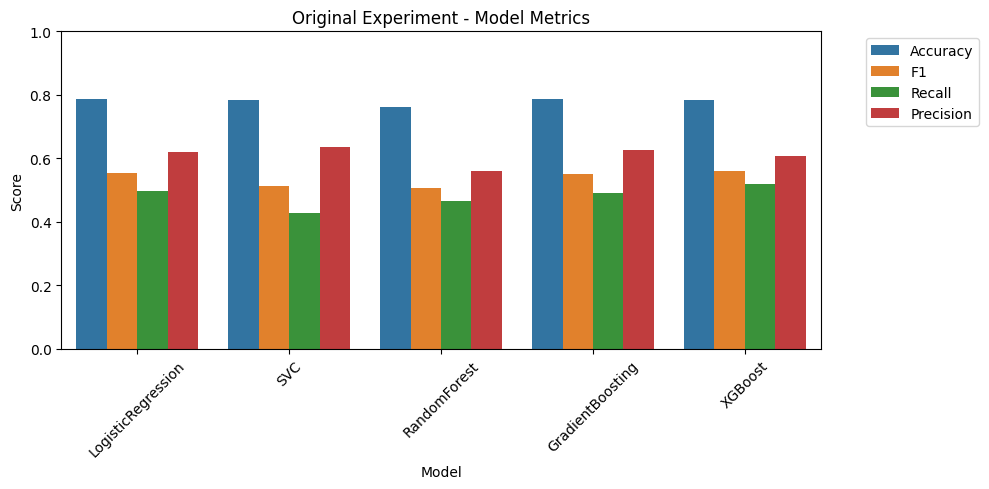

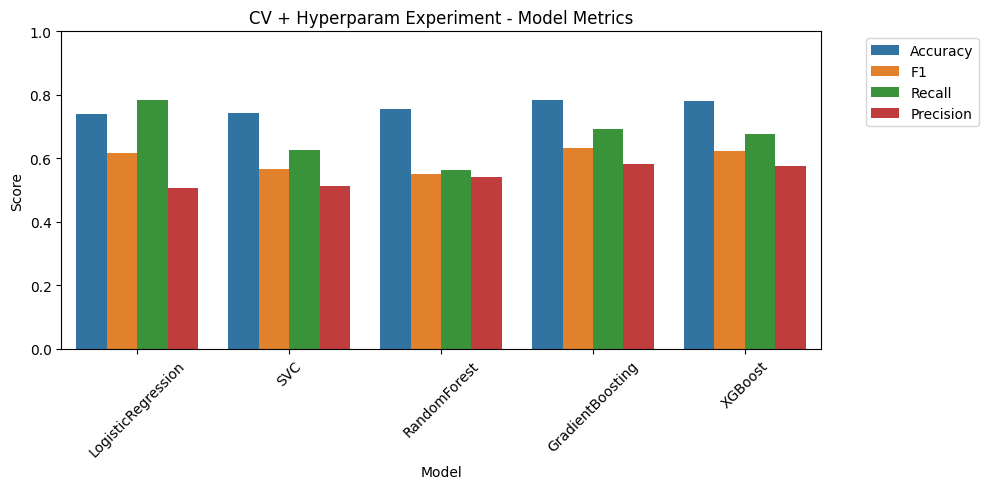

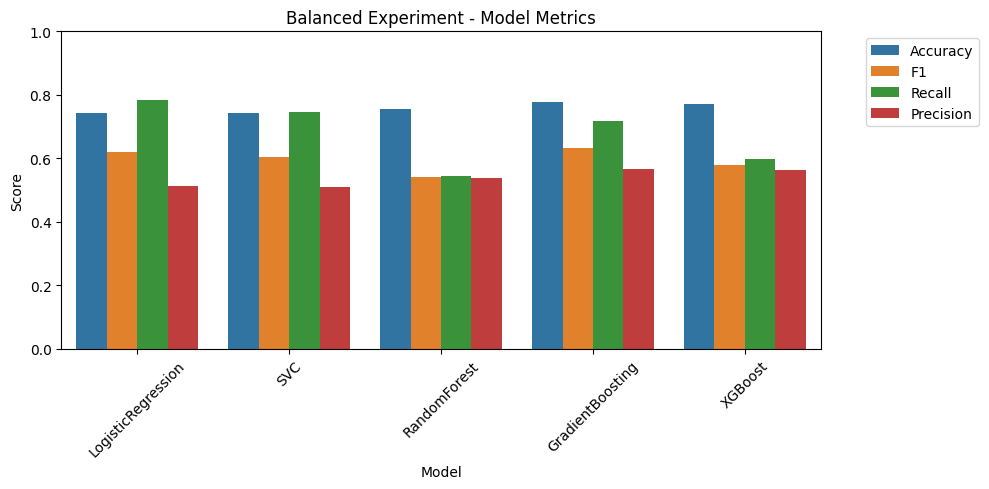

In [103]:
# Combine experiments in a dictionary for easy iteration
experiment_dict = {
    "Original": expA_results,
    "CV + Hyperparam": expB_results,
    "Balanced": expC_results
}

# Iterate through experiments
for exp_name, df_exp in experiment_dict.items():

    # Melt for seaborn plotting
    df_melted = df_exp.melt(
        id_vars=["Model"],
        value_vars=["Accuracy", "F1", "Recall", "Precision"],
        var_name="Metric",
        value_name="Score"
    )

    # Plot
    plt.figure(figsize=(10,5))
    sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric")
    plt.title(f"{exp_name} Experiment - Model Metrics")
    plt.ylim(0,1)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [104]:
all_results = pd.concat([expA_results, expB_results, expC_results])

# Identify the best model based on F1-score, prioritizing the balanced experiment results if available
best_model_expC = expC_results.loc[expC_results['F1'].idxmax()]
best_model_expB = expB_results.loc[expB_results['F1'].idxmax()]
best_model_expA = expA_results.loc[expA_results['F1'].idxmax()]

print("\n--- Best Model Selection ---")
print("Best F1-score from Balanced Experiment (Experiment C):")
display(best_model_expC)

print("\nBest F1-score from CV + Hyperparam Experiment (Experiment B):")
display(best_model_expB)

print("\nBest F1-score from Original Experiment (Experiment A):")
display(best_model_expA)



--- Best Model Selection ---
Best F1-score from Balanced Experiment (Experiment C):


Model         GradientBoosting
Accuracy              0.778673
F1                    0.632573
Recall                0.716578
Precision             0.566197
Experiment            Balanced
Name: 3, dtype: object


Best F1-score from CV + Hyperparam Experiment (Experiment B):


Model         GradientBoosting
Accuracy              0.785308
F1                    0.631408
Recall                0.691622
Precision             0.580838
Experiment     CV + Hyperparam
Name: 3, dtype: object


Best F1-score from Original Experiment (Experiment A):


Model          XGBoost
Accuracy      0.782938
F1            0.559615
Recall        0.518717
Precision     0.607516
Experiment    Original
Name: 4, dtype: object

## 6. Save the Best Model